Hidden channels don’t have a predefined meaning, and it’s up to the update rule to decide what to use them for. They can be interpreted as concentrations of some chemicals, electric potentials or some other signaling mechanism that are used by cells to orchestrate the growth. In terms of our biological analogy - all our cells share the same genome.

(Maybe they can somehow represent the complex state)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated


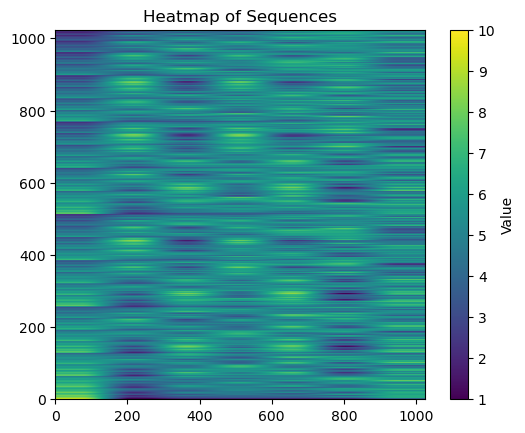

In [114]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
#Seedings and Config
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
# 2100 outer totalistic  Generating Data
samples=500
gridsize=10
data_size, wspan, hspan = (samples, gridsize, 1)
#since 1d ca have fewer states, generate all possible initial conditions
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],      [1]         ,[1]      ,[1]     ,[1]      ,[0]      ,[0],     [0 ]]])


sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

collapsed_sequences=collapse_sequences(sequences)

n = gridsize

plt.imshow(collapsed_sequences, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences.shape[0], 0,
                   collapsed_sequences.shape[0]], vmin=1, vmax=n,
          )
plt.colorbar(label='Value')
plt.title('Heatmap of Sequences')


np.random.shuffle(sequences)
x_sequence=sequences[:,3:6]
y_sequence=sequences[:,6]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot = tf.squeeze( tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes)
split_index = round(samples*0.85)

x_train, x_val = x_sequence[:split_index] , x_sequence[split_index:]     
 
y_train, y_val = Y_val_onehot[:split_index], Y_val_onehot[split_index:]
split_index=len(y_val)//2
y_val, y_test = y_val[:split_index], y_val[split_index:]
x_val, x_test = x_val[:split_index] , x_val[split_index:]   

 


loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                             tf.reshape(y, shape=(-1, num_classes)),
                                                             from_logits=True)

shape = (gridsize, 1)
 
input_shape = (-1, MEMORY_CONSTANT*10)
output_shape = (1, 10)

model = tf.keras.Sequential()
 
diameter = 2*1+1
input_shape = (MEMORY_CONSTANT, gridsize* 1)

 
 

In [115]:
y_sequence

array([[1, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 0]])

# Regular "blind approach". Should maybe try a grid search on the server or look for open source architectures. 

In [117]:
memory_horizon=3
print(y_train[0].shape)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
model.add(tf.keras.layers.SimpleRNN(units=3, activation='tanh', return_sequences=False))
model.add(tf.keras.layers.Dense(units=32, activation="relu", kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()) )
model.add(tf.keras.layers.Dense(units=32, activation="relu" , kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal())),
model.add(tf.keras.layers.Dense(units=32, activation="relu" , kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.Dense(units=10, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
x_train=x_train.reshape(-1,30,1)
model.fit(x_train, y_train, validation_data=(x_val.reshape(-1,30,1),y_val), epochs=30       , batch_size=1,callbacks=[early_stopping_callback])
 
 



(10,)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_190 (Dense)           (None, 32)                128       
                                                                 
 dense_191 (Dense)           (None, 32)                1056      
                                                                 
 dense_192 (Dense)           (None, 32)                1056      
                                                                 
 dense_193 (Dense)           (None, 10)                330       
                                                                 
Total params: 2,585
Trainable params: 2,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
425/425 [=========================

KeyboardInterrupt: 

## Grid search

# from itertools import product

# Define hyperparameters to search
 
units_values = [4,7, 14, 18]  # Different numbers of LSTM units
dense_layers = [1, 2,3]  # Number of dense layers
dense_units_values = [12,32,63, 128]  # Different numbers of dense units
 
best_model = None
best_val_accuracy = 0.0

# Loop through each combination
for lstm_units, num_dense_layers, dense_units in product(units_values, dense_layers, dense_units_values):
    
    # Create the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))

 
 
    model.add(tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=False))
    
    # Add Dense layers
    for _ in range(num_dense_layers):
        model.add(tf.keras.layers.Dense(units=dense_units, activation="relu",
                                        kernel_initializer=tf.keras.initializers.Ones(),
                                        bias_initializer=tf.keras.initializers.he_normal()))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=10, activation="softmax",
                                    kernel_initializer=tf.keras.initializers.Ones(),
                                    bias_initializer=tf.keras.initializers.he_normal()))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss, metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    # Train the model using your data
    early_stopping_callback = CustomCallback()
    x_train = x_train.reshape(-1, 30, 1)
    history = model.fit(x_train, y_train, validation_data=(x_val.reshape(-1, 30, 1), y_val), epochs=30, batch_size=4, callbacks=[early_stopping_callback])
    
    # Find the best model based on validation accuracy
    max_val_accuracy = max(history.history['val_accuracy'])
    
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_model = model

# The best model is stored in the 'best_model' variable
print("Best Validation Accuracy:", best_val_accuracy)

In [109]:
best_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 4)                 96        
                                                                 
 dense_58 (Dense)            (None, 32)                160       
                                                                 
 dense_59 (Dense)            (None, 32)                1056      
                                                                 
 dense_60 (Dense)            (None, 32)                1056      
                                                                 
 dense_61 (Dense)            (None, 10)                330       
                                                                 
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
_________________________________________________________________


## Open Source architecture  1 pytortch

In [174]:
x_train.shape

(750, 30, 1)

In [28]:
x_test=x_test.reshape(1,-1,3,10)
predictions = model.predict(x_test)

final=[]
errors=[]
for grid in predictions:
    for row in grid:
     res=[-1,-1]
     res[np.argmax(row)]=1
     res[np.argmin(row)]=0
     #Only relevant if network does not acchieve 100% accuracy
     if(res[0]==-1 or res[1]==-1):
         res[0]=1
         res[1]=0
         errors.append(row)
     final.append(res)
y_test_reshaped=np.array(y_test).reshape(-1,10,2)
final_pred_reshaped=np.array(final).reshape(-1,10,2)
accuracy = (y_test_reshaped == final_pred_reshaped).mean()
print(f"Test Accuracy: {accuracy} Test-Set Size: {len(x_test)}")
print(f"Errors: {len(errors)}")

ValueError: in user code:

    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 30, 1), found shape=(None, 250, 3, 10)


In [ ]:
gol = CaMemory1D(grid_size=10 , rule_type=RuleTypes.Default,
            memory_type=MemoryTypes.Most_Frequent, memory_horizon=2)


gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],[1],[0],[1],[0],[0],[1],[0 ]]])
gol.set_state_reset([1,0,0,1,1,0,0,1,0,0])
gol.step_multiple(10)
 
gol.render_state()

In [32]:
x_val.shape

(25, 3, 10)

(None, 2, 100)


In [279]:
def most_frequent_state(grids):
    rows, cols = grids[0].shape
    most_frequent = np.zeros((rows, cols), dtype=int)

    for i in range(rows):
        for j in range(cols):
            value_counts = {}
            recent_value = -1
            max_count = 0

            for idx, grid in enumerate(grids):
                cell_value = grid[i, j]

                if cell_value not in value_counts:
                    value_counts[cell_value] = 1
                else:
                    value_counts[cell_value] += 1

                if value_counts[cell_value] > max_count or (value_counts[cell_value] == max_count and idx > recent_value):
                    max_count = value_counts[cell_value]
                    recent_value = idx

            most_frequent[i, j] = grids[recent_value][i, j]

    return most_frequent

# Example usage
n = 2  # Number of 2D grids
grid_size = 10  # Size of each grid (assuming square grid)

grids = [np.random.choice([0, 1], size=(grid_size, grid_size)) for _ in range(n)]
result = most_frequent_state(xs[2:4])

print("Input Grids:")
for grid in grids:
    print(grid)
    
print("\nMost Frequent State:")
print(result)
gol_m.mostFrequentPastStateBinaryProvided(xs[2:4])

Input Grids:
[[1 1 0 1 0 1 0 0 0 1]
 [0 0 0 0 1 1 0 1 1 0]
 [0 1 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 1 1 1 1]
 [1 0 1 1 0 0 1 1 0 1]
 [1 1 0 0 1 1 0 0 0 0]
 [1 1 1 0 1 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 1 1 0 0]
 [1 1 0 0 1 1 0 0 0 1]]
[[0 0 0 1 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 1 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 1 1 0 0 0 1]
 [1 1 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 1 1]
 [0 1 1 1 0 0 1 1 0 0]
 [1 1 1 1 0 1 0 0 0 1]
 [0 1 1 1 0 1 1 0 0 0]]

Most Frequent State:
[[0 0 0 0 1 0 1 0 0 1]
 [1 0 1 1 1 0 0 1 1 1]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 0 1]
 [1 0 1 1 1 1 0 0 1 0]
 [0 1 1 0 0 1 0 1 0 1]
 [1 0 1 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 0]]


array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0]])

In [22]:
array_3d = x_sequence

# Count the number of 0s and 1s in the array
num_zeros = np.count_nonzero(array_3d == 0)
num_ones = np.count_nonzero(array_3d == 1)

# Calculate the ratio of 0s to 1s
if num_ones != 0:
    ratio_zeros_to_ones = num_zeros / num_ones
else:
    ratio_zeros_to_ones = float('inf')  # Set to infinity if there are no ones

print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)
print("Ratio of 0s to 1s:", ratio_zeros_to_ones)

Number of 0s: 158396
Number of 1s: 51604
Ratio of 0s to 1s: 3.0694519804666305


In [24]:
array_3d = x_sequence

# Count the number of 0s and 1s in the array
num_zeros = np.count_nonzero(array_3d == 0)
num_ones = np.count_nonzero(array_3d == 1)

# Calculate the ratio of 0s to 1s
if num_ones != 0:
    ratio_zeros_to_ones = num_zeros / num_ones
else:
    ratio_zeros_to_ones = float('inf')  # Set to infinity if there are no ones

print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)
print("Ratio of 0s to 1s:", ratio_zeros_to_ones)

Number of 0s: 105087
Number of 1s: 104913
Ratio of 0s to 1s: 1.00165851705699


In [74]:
shape=(10,10)
layer_dims=[10,10]
nhood=1 
num_classes=2
totalistic=False
nhood_type="moore"
bc="same"

wspan, hspan = shape
diameter = 2*nhood+1
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((wspan, hspan, 1)))
 
for i in range(1, len(layer_dims)):
    model.add(tf.keras.layers.Dense(layer_dims[i],  activation='relu',
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
#model.add(tf.keras.layers.Reshape(target_shape=(-1, wspan, hspan)))
 

In [63]:
array_3d[0]

NameError: name 'array_3d' is not defined

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...


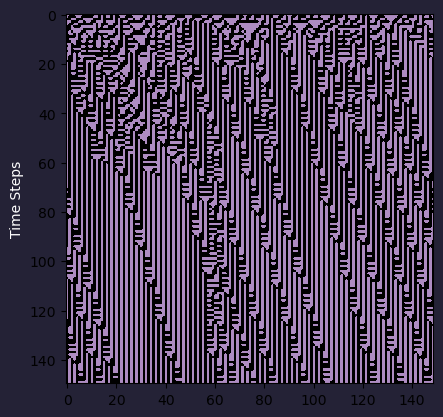

[0.4563758389261745, 0.5100671140939598, 0.5234899328859061, 0.5436241610738255, 0.4563758389261745, 0.5100671140939598, 0.5100671140939598, 0.47651006711409394, 0.5771812080536913, 0.5100671140939598, 0.5234899328859061, 0.5369127516778524, 0.5436241610738255, 0.6040268456375839, 0.5100671140939598, 0.5369127516778524, 0.5369127516778524, 0.5234899328859061, 0.5100671140939598, 0.46308724832214765, 0.5436241610738255, 0.5033557046979866, 0.5302013422818792, 0.5369127516778524, 0.5503355704697986, 0.5302013422818792, 0.5771812080536913, 0.47651006711409394, 0.610738255033557, 0.4563758389261745, 0.5369127516778524, 0.5167785234899329, 0.5302013422818792, 0.5503355704697986, 0.48322147651006714, 0.5234899328859061, 0.5302013422818792, 0.5570469798657718, 0.5234899328859061, 0.5570469798657718, 0.5234899328859061, 0.5436241610738255, 0.5033557046979866, 0.5570469798657718, 0.4697986577181208, 0.5369127516778524, 0.5167785234899329, 0.5503355704697986, 0.5033557046979866, 0.52348993288590

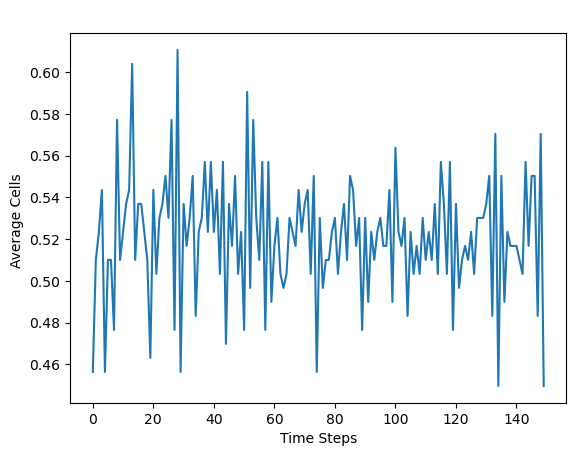

<Figure size 640x480 with 0 Axes>

In [8]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes

%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
#Seedings and Config
 

print("Starting...")
SEED =2
random.seed(SEED)
np.random.seed(SEED)
gridsize=149
x_values = [seq for seq in itertools.product("01", repeat=10)]

x_values = [[int(bit) for bit in seq] for seq in x_values]
#x_value = np.random.choice([0, 1], gridsize, p=[.5, .5])

MEMORY_CONSTANT=6
 

 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT,initial_state=x_value)


gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],      [1]         ,[1]      ,[1]     ,[1]      ,[0]      ,[0],     [0 ]]])

gol.step_multiple(149)
gol.render_state()
gol.plot_evolultion()
plt.savefig('rule300.png')

a larger grid allows fore more expressive data

# Visualize Dataset of sequences

Text(0.5, 1.0, 'Heatmap of Sequences')

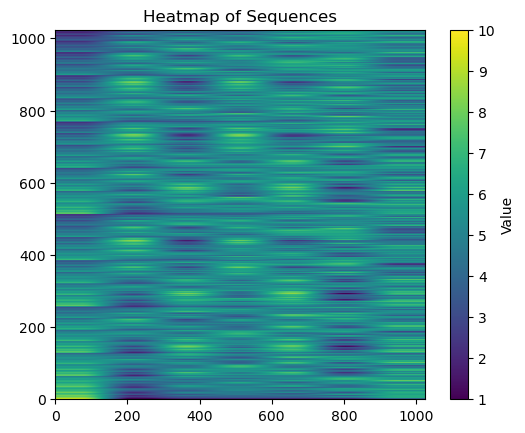